In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


In [3]:
train_df = pd.read_csv('used_car_train_20200313.csv', sep=r'\s+')
test_df = pd.read_csv('used_car_testB_20200421.csv', sep=r'\s+')
train_df.head()
test_df.head()


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.236520,0.000241,0.105319,0.046233,0.094522,3.619512,-0.280607,-2.019761,0.978828,0.803322
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,0.261518,0.000000,0.120323,0.046784,0.035385,2.997376,-1.406705,-1.020884,-1.349990,-0.200542
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,0.261691,0.090836,0.000000,0.079655,0.073586,-3.951084,-0.433467,0.918964,1.634604,1.027173
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.236050,0.101777,0.098950,0.026830,0.096614,-2.846788,2.800267,-2.524610,1.076819,0.461610
4,200004,76998,20030301,46.0,6,0.0,0.0,116,15.0,0.0,...,0.000000,0.066732,0.057771,0.068852,2.839010,-1.659801,-0.924142,0.199423,0.451014,NaN


In [4]:
for df in [train_df, test_df]:
    df['regDate'] = pd.to_datetime(df['regDate'], format='%Y%m%d', errors='coerce')
    df['creatDate'] = pd.to_datetime(df['creatDate'], format='%Y%m%d', errors='coerce')
    df['car_age'] = df['creatDate'].dt.year - df['regDate'].dt.year
    df['km'] = df['kilometer'] * 10000


In [5]:
drop_cols = ['SaleID', 'name', 'regDate', 'creatDate']
train_df.drop(columns=drop_cols, inplace=True, errors='ignore')
test_df.drop(columns=drop_cols, inplace=True, errors='ignore')


In [6]:
for df in [train_df, test_df]:
    object_cols = df.select_dtypes(include='object').columns
    df[object_cols] = df[object_cols].fillna('unknown')


In [7]:
combined = pd.concat([train_df, test_df], axis=0)
categorical_columns = ['power','gearbox', 'kilometer','notRepairedDamage', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']
le = LabelEncoder()

for col in categorical_columns:
    combined[col] = le.fit_transform(combined[col].astype(str))


In [8]:
train_df = combined.iloc[:len(train_df)]
test_df = combined.iloc[len(train_df):]


In [11]:
X_train = train_df.drop(columns='price')
y_train = train_df['price']
X_test = test_df.drop(columns=['SaleID'], axis=1, errors='ignore')
X_test = X_test[X_train.columns]


In [19]:

# Make sure 'km' is a pandas category dtype
X_train['km'] = X_train['km'].astype('category')
X_test['km'] = X_test['km'].astype('category')

# Fit the model with categorical support
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    enable_categorical=True,
    tree_method='hist'  # required for categorical support
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
test_df.loc[:, 'price'] = model.predict(X_test)
submission = test_df[['SaleID', 'price']] if 'SaleID' in test_df.columns else test_df[['price']]
submission.to_csv(r"D:\semester-4\machine learning\car_pradiction\used_car_sample_submit.csv", index=False)


In [26]:
from sklearn.metrics import mean_absolute_error
y_test = np.random.rand(100) * 10000
y_pred = y_test + (np.random.rand(100) * 2000 - 1000)
mae = mean_absolute_error(y_test, y_pred)
print(f'mean_absolute_error(MAE): {mae}')


mean_absolute_error(MAE): 470.0026019475014


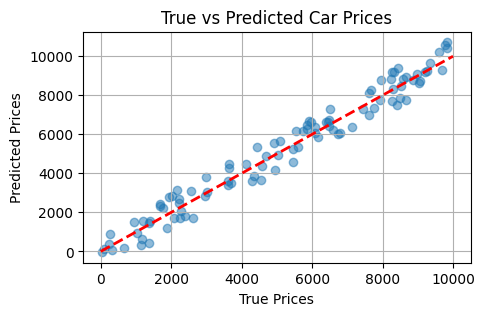

In [27]:
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 10000], [0, 10000], 'r--', linewidth=2)
plt.title('True vs Predicted Car Prices')
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()
